**1. Creating function tic and toc like it Matlab**

It's important to have an idea how much time it takes to finish the program execution. The tic mark the start of the count and the toc the finish.

In [0]:
def tic():
  import time
  global startTime_for_tictoc
  startTime_for_tictoc = time.time()

def toc():
  import time
  if 'startTime_for_tictoc' in globals():
    print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
  else:
    print("Toc: start time not set")

**2. Input arguments**

Here are the program input parameters. The operator should only change the parameters in this field to obtain the desired result.



*   thermal_image: name of the image file to be processed;
*   reference_temperature_max:  maximum temperature shown by the thermal imager;
*   reference_temperature_min: minimum temperature shown by the thermal imager;
*   pixel_step: influences the amount of pixels of the image that will be processed. The higher, the faster the image is processed, but the results are less precise;
*   tolerance: parameter that indicates how much error will be accepted for image processing. The higher these parameter, the higher are the chances of each pixel having some corresponding temperature value, but the greater the error added to the reading value;
*   name_file_csv: Name of the file to be saved.



In [0]:
thermal_image = 'IR_0375.jpg'
reference_temperature_max = 131
reference_temperature_min = 25.5
pixel_step = 1
tolerance = 5
name_file_csv = 'FLIR_B300_CODE.csv'

**3. Image reading**

Performing a reading of the RGB components of each pixel in the image.

In [0]:
import cv2
image_color_data = cv2.imread(thermal_image,1)
reference_color_data = image_color_data[61:177,297:305,:]

**4. Imagem showing**

Displays the image that has been read by the program. This helps show which is the program input image.

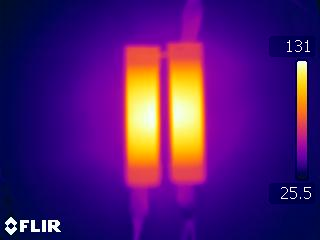

In [0]:
from IPython.display import Image
Image(thermal_image)

**5. Temperature reference**

Generates a list of the possible temperature values that can be obtained in the image. Note that this list is made with the help of the color bar.

In [0]:
import numpy as np
reference_max_pixel = len(reference_color_data)
reference_temperature = np.zeros(shape = (reference_max_pixel))
for t in range(0,reference_max_pixel):
  reference_temperature[t] = reference_temperature_max - (reference_temperature_max-reference_temperature_min)*((t)/float(reference_max_pixel-1))

**6. Temperature image**

This is the most time consuming part of running the program, so the tic and toc function is used. It scans each pixel in the input image and tries to find a temperature that best represents that pixel with the RGB components. Note that there is a tolerance for this conversion. Pixels that do not have a temperature that well-represents, are filled with the value nan (not a number).

In [0]:
tic()
thermal_xmax = len(image_color_data)
thermal_ymax = int(image_color_data.size/(3*thermal_xmax))
cond_color = [0,0,0]
thermal_temperature = np.zeros(shape = (thermal_xmax, thermal_ymax))
thermal_temperature[:] = np.nan
while thermal_xmax % pixel_step + thermal_ymax % pixel_step != 0:
  pixel_step = pixel_step - 1
reference_max_pixel_c = int(reference_color_data.size/(reference_max_pixel*3))
for reference_pixel_c in range(0,reference_max_pixel_c):
  for thermal_x in range(0,thermal_xmax,pixel_step):
    for thermal_y in range(0,thermal_ymax,pixel_step):
      if np.isnan(thermal_temperature[thermal_x,thermal_y]) == True:
        for reference_pixel in range(0,reference_max_pixel):
          for count_color in range(0,3):
            if image_color_data[thermal_x,thermal_y,count_color] > reference_color_data[reference_pixel,reference_pixel_c,count_color]:
              if image_color_data[thermal_x,thermal_y,count_color] - reference_color_data[reference_pixel,reference_pixel_c,count_color] <= tolerance:
                cond_color[count_color] = 1;
              else:
                cond_color[count_color] = 0;
            else:
              if reference_color_data[reference_pixel,reference_pixel_c,count_color] - image_color_data[thermal_x,thermal_y,count_color] <= tolerance:
                cond_color[count_color] = 1;
              else:
                cond_color[count_color] = 0;
          if cond_color[0] == 1 and cond_color[1] == 1 and cond_color[2] == 1:
            thermal_temperature[thermal_x,thermal_y] = reference_temperature[reference_pixel]
toc()

Elapsed time is 193.845617056 seconds.


**7. Save as a csv file**

It is important, after having scanned, that the obtained data be saved in a csv file so that it can be used later.

In [0]:
import csv
myFile = open(name_file_csv, 'w')
with myFile:
  writer = csv.writer(myFile)
  writer.writerows(thermal_temperature)

**8. Showing obtained results**

Getting a graphical view of the result is always important to get a sense of how the results behave.

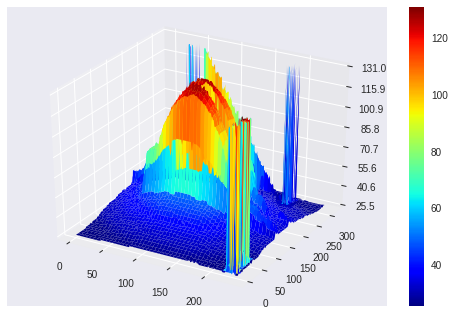

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(0, thermal_x, pixel_step)
Y = np.arange(0, thermal_y, pixel_step)
X, Y = np.meshgrid(X, Y)
Z = thermal_temperature[X,Y]

surf = ax.plot_surface(X, Y, Z, cmap=cm.jet, vmin = reference_temperature_min, vmax =reference_temperature_max)
ax.set_zlim(reference_temperature_min, reference_temperature_max)
ax.zaxis.set_major_locator(LinearLocator(8))
fig.colorbar(surf, fraction = 0.1)
plt.show()